# BurstPy: a Quick Walkthrough
This is a quick walkthrough of the autocorrelation statistical analysis package I put together working for the Lagha Lab at IGMM in Montpellier, France. 
### What does it do?
The purpose of this software package is to quantify *"bursty"* transcription dynamics in fly embryos. Due to noise and stochastic (random) variability in GFP MS2 signal cell-to-cell, an autocorrelation approach is necessary to decipher the patterns by which gene promoters start and stop transcription. We rely primarily on the derivation in Desponds et al (2016) for extracting two-state promoter dynamics from data.

### What do I need to run it?
The package runs on Python 3, and will (eventually) be implemented into its own, standalone GUI interface for easy access within the lab environment. 

## Why Autocorrelation?
Recent advancements in gene splicing have made it possible to track transcriptional processes (in *drosophila* embryos) in real time. The MS2 GFP cassette, a string of fluorescing molecules, can be attached to an RNA Polymerase (polII) as it transcribes a section of a gene.  The result is a flourescent signal that can be tracked and measured over time to illuminate how these polymerases behave during transcription. 

Although the MS2 system is in itself a breakthrough, the resulting signals or "traces" from each transcribing cell are inherently random signals--that is, they stem from a fundamentally *stochastic* process. What's more, measurement noise and cell-to-cell variability can obscure dynamics even more, making it impossible to resolve single traces by eye.

Signal autocorrelation is an approach that bypasses many of these issues. Autocorrelation compares a random signal, $X(t)$ with itself at every time point, "sliding" the function along itself. Let's assume for now that $X(t)$ can either be "ON" or "OFF", each state for a random duration of time. The autocorrelation function tells us to what degree a signal "remembers" itself being either "ON" or "OFF". That is, how similar is the signal at time $t$, $X(t) = X_t$, to itself at time $s$, when the signal $X(t)$ = $X_s$?

The equation that describes this process is:

  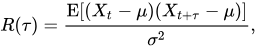   

where $\mu$ is the mean of the signal, and $\sigma^2$ is the variance.
A good illustration (courtesy of Wikipedia):

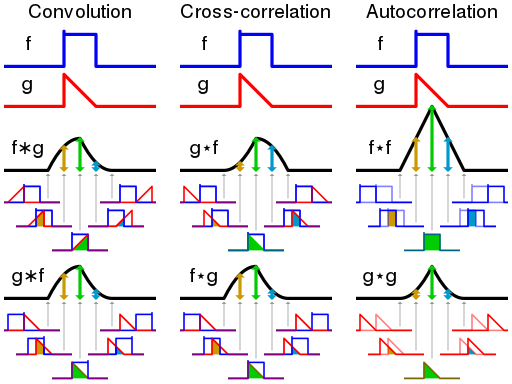


Following some mathematical derivation (which I might include later for a Poisson process), we find that the autocorrelation function takes the form of an exponential decay curve, dependent solely on the time *delay* between comparison points in the signal $X(t)$.

The characteristic decay time, $\tau_{char}$, can be linked to the *underlying random distribution* that tells $X(t)$ how long to stay "ON" or "OFF". In the case of Poisson-distributed wait durations, $\tau_{char}$ is the mean of the distribution. 

## Two-State Promoter: A more realistic system
In the biological context of our transcription system, our gene promoter is what takes the form of the "ON/OFF" signal $X(t)$. This promoter (we assume) turns "ON" and calls in polII molecules to start converting DNA to mRNA. However, we know qualitatively that "OFF" times are generally different (longer) than "ON" times in transcription. We therefore *make the assumption* that our "ON" and "OFF" state durations are related each to an exponential distribution centered on $k_{on}$ and $k_{off}$, respectively.

When a promoter is "ON", a polII will hop onto the gene and begin transcribing with a given speed, $k_{elong}$, collecting GFP loops and producing a growing signal. As a result, the "telegraph" ON/OFF signal becomes *convolved* with the linearly-growing GFP signal, as in the example below:

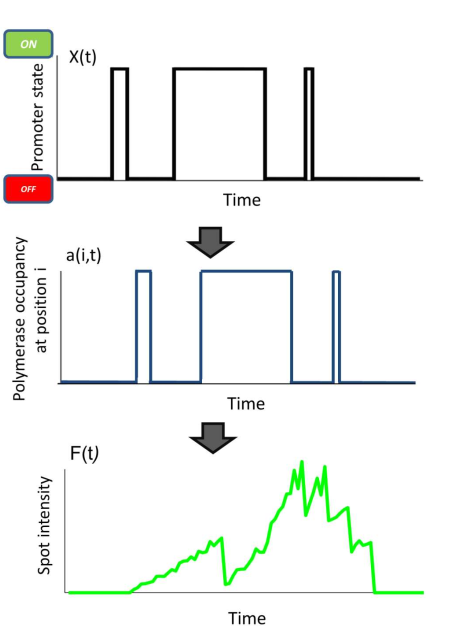

This fluorescent signal is inherently noisy, so performing an autocorrelation analysis on a single cell's trace will result in something like this:

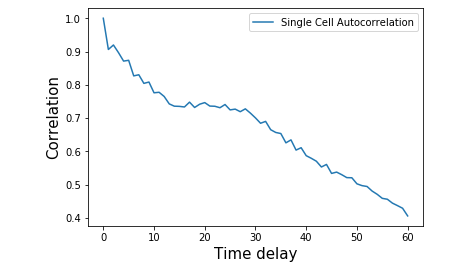

So, to get around this, we take a look at an **average** autocorrelation of **~40-100** cell traces in a local region. To compute this autocorrelation, we normalize each trace $I(t)$ by the mean of the maximum intensities of all cells in the region, $I_o$. We then subtract out the mean value of each trace. The result is:

$$ <F(t)> = \frac{I(t) - \mu_{I(t)}}{I_o} $$

Then, autocorrelating each corrected trace, $<F(t)>$ and taking the average of all autocorrelations, we obtain something like this:

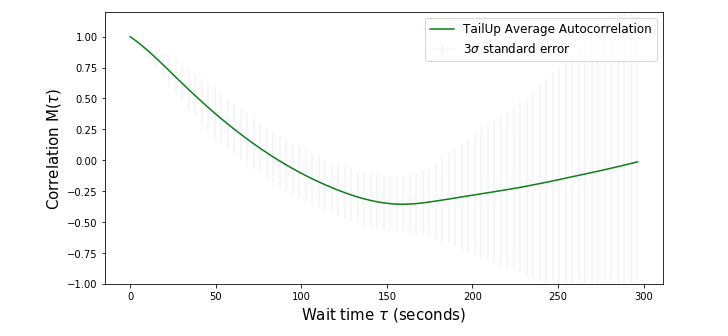

This smooths out the shape such that we get a fittable curve. 

## Adapting Desponds et al's Two-State System
In their 2016 paper, Desponds et al derived a link between these two distributions and the resulting autocorrelation function of random MS2 signals. The crux of this paper is knowing a single polII's MS2 construct, by basepair, $L(i)$. The normalized fluorescent signal, $<F(t)>$, is related to this fluorescent construct by the relation:

$$<F(t)> = P_{on}\sum_{n=1}^{r} L_i $$

Where $P_{on}$ is the average time the set of traces spend in the "ON" position, and $r$ is the maximum number of loops allowed by the MS2 construct. The sum over $L(i)$ at each gene position $i$ represents a single polII's total contribution to the average florescence.

$P_{on}$, once fitted for from the calibrated average fluorescence, $<F(t)>$, can be used to *decouple* $k_{on}$ and $k_{off}$ through the relation:

$$P_{on} = \frac{k_{on}}{k_{on} + k{off}} $$


Much of the publication was the derivation of a fine-tuned, finite-length *analytic* autocorrelation function for short cell signals, dependent on the MS2 loop construct. Fitting via least-squares optimization (for example) for this two-state autocorrelation infers the characteristic time, $\tau_{char}$ from the average autocorrelation of cell traces. The analytic two-state model is: 


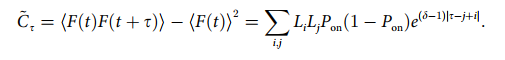

where $\tau$ is the time delay between points in the signal and $L_i$ are the MS2 loop functions, indexed by position $i$ on the gene. The function is fitted for $\delta = 1 - (k_{on} + k_{off})$, which gives the characteristic time $\tau_{char}$ of the decay curve.

Desponds et al then introduced a finite correction to this function, which "smooths out" to the infinite solution (above) as cell signals increase:

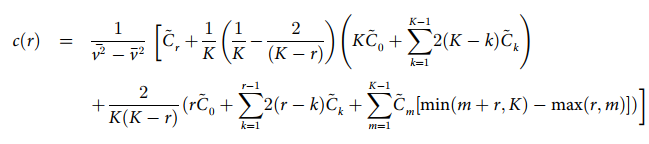

Don't worry about the mathematical semantics here. The point is that **this function is fine-tuned to handle short cell signals**.


### Le But (the gist)

Knowing that $(k_{on} + k_{off})^{-1} = \tau_{char}$, we can now infer all parameters of our biological system by fitting 

**1) Pon from calibrated trace data** 

and

**2) $\tau_{char}$ from Desponds' analytic autocorrelation function**





## BurstPy example
Ok, now that we've looked through the basis of our two-state system, let's take a look at an example using the BurstPy package.

For this example, we're going to be working from a folder called "BurstPy". Eventually, I hope to get the package incorporated as a Python library, but let's not get ahead of ourselves.

Once we're navigated to our BurstPy folder, let's pull in all of the packages that we're going to need for our analysis:

In [ ]:
# These are all of the published Python packages
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.optimize import curve_fit